# Fraud Detection

The **Fraud Detection** project focuses on analyzing **financial transactions** to identify fraudulent activities within a digital payment system. The dataset contains approximately **6.3 million transactions**, each representing various types of money movements between users. Some transactions were incorrectly flagged by existing systems, providing an opportunity to improve detection through feature engineering and machine learning.

Each transaction in the dataset contains the following key information:

* **Step:** Denotes a portion of the time period in which the transaction occurred.
* **Type:** Transaction type, including CASH-IN, CASH-OUT, PAYMENT, TRANSFER, and DEBIT.
* **Amount:** The numeric value of the transaction.
* **OldbalanceOrg / NewbalanceOrig:** Source account balance before and after the transaction.
* **OldbalanceDest / NewbalanceDest:** Target account balance before and after the transaction.
* **isFraud:** Target variable, where 1 indicates a fraudulent transaction and 0 indicates legitimate.

**Data preprocessing** included removing irrelevant string columns, handling zero balances, encoding the categorical `type` column, and creating new features through **feature engineering**, such as:

* `balance_diff`: difference between the source account's old and new balances.
* `dest_balance_diff`: difference between the target account's new and old balances.
* `amount_ratio_org`: transaction amount as a proportion of the sender’s old balance.
* `amount_ratio_dest`: transaction amount as a proportion of the receiver’s old balance.

**Exploratory Data Analysis (EDA)** was performed to understand patterns in the data, including:

* Checking distribution of balances and transaction amounts.
* Bar plots for fraud vs non-fraud transactions.
* Correlation heatmaps to identify relationships between features and the target variable.

After preprocessing and EDA, the dataset was **split into training and testing sets**, with SMOTE applied to the training data to handle the class imbalance (fraud cases being <0.2%).

A **machine learning model** was trained on the processed data to predict fraudulent transactions. The model was evaluated using metrics such as **accuracy, ROC-AUC, precision, recall, F1-score, and the confusion matrix**, achieving strong performance in detecting fraud despite the highly imbalanced dataset.

Dataset is hosted on Kaggle due to size limits, please download here **www.kaggle.com/datasets/amanalisiddiqui/fraud-detection-dataset/data*

In [1]:
# importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [2]:
# importing the data set
df = pd.read_csv('AIML Dataset.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Data Preprocessing

In [3]:
# dropping unnecessary columns
df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'],axis=1,inplace=True)

In [7]:
# checking for the missing values
df.isnull().sum()

step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

In [6]:
# checking the data types of the columns
df.dtypes

step                int64
type               object
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
dtype: object

### Feature Engineering

In [8]:
# Balance difference for the sender account
df['balance_diff'] = df['oldbalanceOrg'] - df['newbalanceOrig']
# Explanation: This shows how much the sender’s balance decreased after the transaction. 
# Fraudulent transactions often have a balance_diff equal to the transaction amount, 
# or show abnormal differences compared to legitimate ones.

In [9]:
# Balance difference for the receiver account
df['dest_balance_diff'] = df['newbalanceDest'] - df['oldbalanceDest']
# Explanation: Indicates how much the receiver’s balance increased. 
# This can help the model detect suspicious incoming transactions.

In [10]:
# Percentage of the transaction amount relative to the sender’s balance
df['amount_ratio_org'] = df['amount'] / df['oldbalanceOrg'].replace(0, 1)
# Explanation: Represents what fraction of the sender’s balance was transferred. 
# Fraud cases often involve unusually high percentages, sometimes close to 100%.

In [11]:
# Percentage of the transaction amount relative to the receiver’s balance
df['amount_ratio_dest'] = df['amount'] / (df['oldbalanceDest'].replace(0, 1))
# Explanation: Measures how large the transaction is compared to the receiver’s existing balance. 
# This helps capture transactions where the received amount is disproportionately high.

In [12]:
# label encoding for 'type'
le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])

In [13]:
# check the mapping
mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(mapping)

{'CASH_IN': np.int64(0), 'CASH_OUT': np.int64(1), 'DEBIT': np.int64(2), 'PAYMENT': np.int64(3), 'TRANSFER': np.int64(4)}


In [14]:
# dropping the uncoded 'type'
df.drop(['type'],axis=1,inplace=True)

In [15]:
# checking the data description
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,balance_diff,dest_balance_diff,amount_ratio_org,amount_ratio_dest,type_encoded
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,-2.123056e+04,1.242947e+05,7.068398e+04,2.788615e+04,1.714150e+00
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.466433e+05,8.129391e+05,5.084300e+05,1.879529e+05,1.350117e+00
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.915268e+06,-1.306083e+07,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.344085e-01,1.607038e-01,1.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00,0.000000e+00,6.454800e+00,9.178383e-01,1.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,1.015044e+04,1.491054e+05,1.229616e+04,9.732390e+03,3.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+07,1.056878e+08,9.244552e+07,6.096528e+07,4.000000e+00


## Exploratory Data Analysis

In [17]:
# checking coorelation between the columns isFraud and the other columns
df.select_dtypes(include=['number']).corr()['isFraud'].sort_values()

newbalanceOrig      -0.008148
oldbalanceDest      -0.005885
amount_ratio_org    -0.004916
newbalanceDest       0.000535
oldbalanceOrg        0.010154
type_encoded         0.020833
dest_balance_diff    0.027028
step                 0.031578
amount               0.076688
amount_ratio_dest    0.180184
balance_diff         0.362472
isFraud              1.000000
Name: isFraud, dtype: float64

C:\Users\Windows\AppData\Local\Temp\ipykernel_9760\3394225183.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


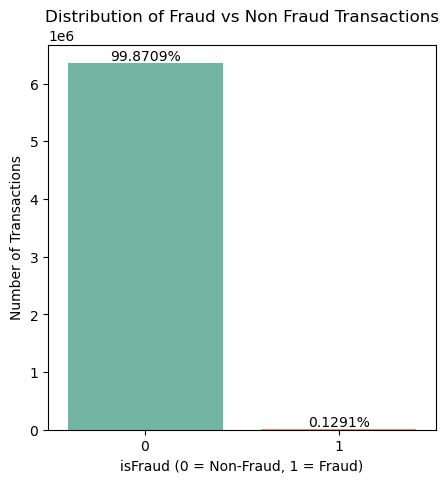

In [18]:
# bar plot for the number of isFraud
plt.figure(figsize=(5,5))

## fraud count
fraud_counts = df['isFraud'].value_counts()
fraud_percent = (fraud_counts / len(df)) * 100

## plot
sns.barplot(
    x=fraud_counts.index,
    y=fraud_counts.values,
    palette='Set2'
)

## adding percentage
for i, count in enumerate(fraud_counts.values):
    plt.text(i, count, f'{fraud_percent[i]:.4f}%', ha='center', va='bottom')

plt.title('Distribution of Fraud vs Non Fraud Transactions')
plt.xlabel('isFraud (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Number of Transactions')
plt.show()

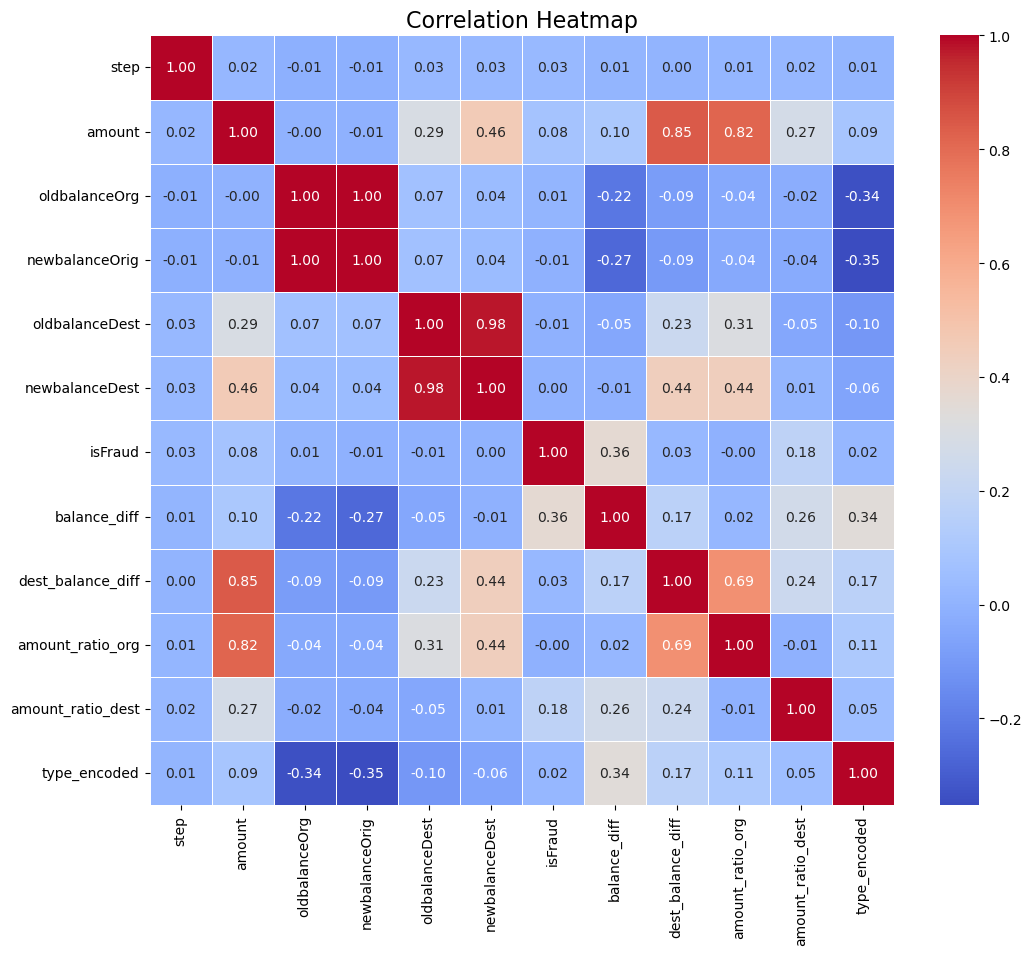

In [19]:
# create a heatmap to check the correlation
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

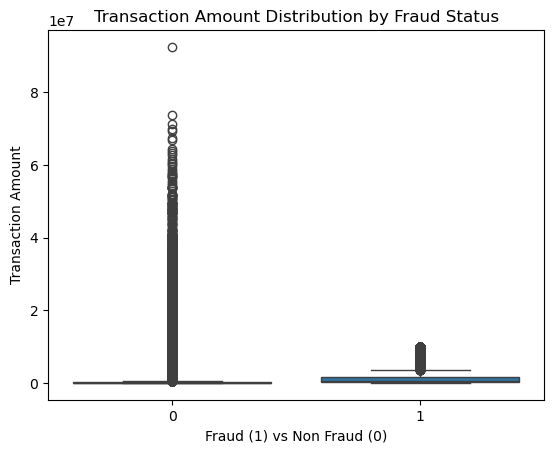

In [20]:
# checking distribution of amount by fraud vs non fraud
sns.boxplot(x='isFraud', y='amount', data=df)
plt.title('Transaction Amount Distribution by Fraud Status')
plt.xlabel('Fraud (1) vs Non Fraud (0)')
plt.ylabel('Transaction Amount')
plt.show()

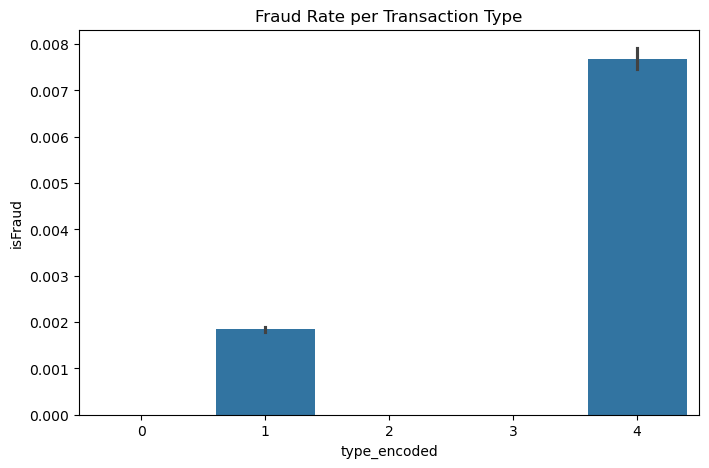

In [24]:
# checking fraud rate per transaction type
plt.figure(figsize=(8,5))
sns.barplot(x='type_encoded', y='isFraud', data=df)
plt.title('Fraud Rate per Transaction Type')
plt.show()

## Train Test Split

In [26]:
from sklearn.model_selection import train_test_split
X = df.drop(['isFraud'], axis=1)
y = df['isFraud']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

## SMOTE

In [27]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

In [29]:
# checking result
y_train.value_counts(normalize=True)   # before SMOTE
y_train_resampled.value_counts(normalize=True)  # after SMOTE

isFraud
0    0.5
1    0.5
Name: proportion, dtype: float64

## Decision Tree Classifier

In [31]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)

DecisionTreeClassifier()

In [32]:
# predicting the diagnosis
y_pred = dtree.predict(X_test)

## Model Evaluation

In [33]:
# printing samples from predicted and actual values
print('Predicted values: ',y_pred[:10])
print('Actual values: ',y_test[:10])

Predicted values:  [0 0 0 0 0 0 0 0 0 0]
Actual values:  3737323    0
264914     0
85647      0
5899326    0
2544263    0
3494160    0
2331654    0
1414955    0
2938135    0
6133806    0
Name: isFraud, dtype: int64


In [34]:
# model evaluation 
print(dtree.score(X_test,y_test))

0.999972233660557


In [35]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [36]:
# checking confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[1906326      25]
 [     28    2407]]


In [37]:
# checking classification report: precision, recall, f1-score
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.99      0.99      0.99      2435

    accuracy                           1.00   1908786
   macro avg       0.99      0.99      0.99   1908786
weighted avg       1.00      1.00      1.00   1908786



In [38]:
# checking ROC-AUC
auc = roc_auc_score(y_test, y_pred)
print("\nROC-AUC Score:", auc)


ROC-AUC Score: 0.9942439563173885


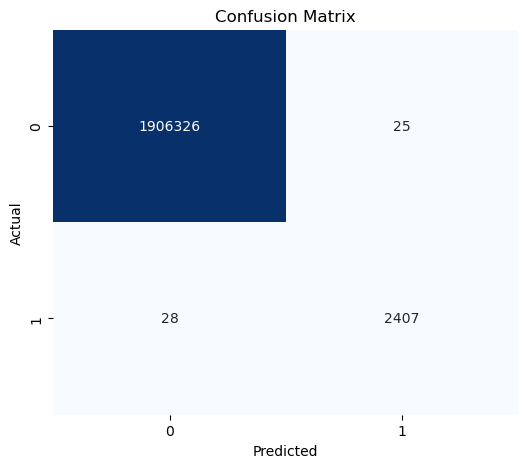

In [39]:
# visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()